# CNN for Image Classification in Keras

In [31]:
import time
import math
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import dataset
import cv2
import os

from sklearn.metrics import confusion_matrix
from datetime import timedelta

from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.constraints import maxnorm
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import History

%matplotlib inline

## Configuration and Hyperparameters

In [45]:
# Convolutional Layer 1.
filter_size1 = 3 
num_filters1 = 32

# Convolutional Layer 2.
filter_size2 = 3
num_filters2 = 32

# Convolutional Layer 3.
filter_size3 = 3
num_filters3 = 64

# Fully-connected layer.
fc_size = 256             # Number of neurons in fully-connected layer.

# Number of color channels for the images: 1 channel for gray-scale.
num_channels = 3

# image dimensions (only squares for now)
img_size = 256

# Size of image when flattened to a single dimension
img_size_flat = img_size * img_size * num_channels

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# class info
classes = ['Pool', 'NonPool']
num_classes = len(classes)

# Dropout value
dropout = .2

# batch size
batch_size = 32

# test split
test_size = .16

# Num epochs
num_epochs = 100

# how long to wait after validation loss stops improving before terminating training
early_stopping = None  # use None if you don't want to implement early stoping

data_path = '../pool-dataset'
checkpoint_dir = "models"

## Load Data

In [3]:
data = dataset.read_train_sets(data_path, img_size, classes, test_size=test_size)

Reading training images
Loading Pool files (Index: 0)
Loading NonPool files (Index: 1)


In [4]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.images)))

Size of:
- Training-set:		8400
- Test-set:		1600


### Helper function for plotting images

Function used to plot 9 images in a 3x3 grid (or fewer, depending on how many images are passed), and writing the true and predicted classes below each image.

In [5]:
def plot_images(images, cls_true, cls_pred=None):
    
    if len(images) == 0:
        print("no images to show")
        return 
    else:
        random_indices = random.sample(range(len(images)), min(len(images), 9))
        
        
    images, cls_true  = zip(*[(images[i], cls_true[i]) for i in random_indices])
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        RGB_img = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
        ax.imshow(RGB_img.reshape(img_size, img_size, num_channels))

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Plot some test images

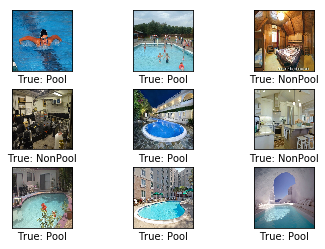

In [6]:
images, cls_true  = data.train.images, data.train.cls

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

## Now, building the network in Keras

The baseline network structure to be used will be as follows:
    1. A convolutional input layer, with 32 3x3 filters, a ReLU activation function and a weight constraint of max norm set to 3.
    2. Dropout
    3. A convolutional layer, with 32 3x3 filters, a ReLU activation function and a weight constraint of max norm set to 3.
    4. Dropout
    5. Convolutional layer, 64 feature maps with a size of 3×3, a rectifier activation function and a weight constraint of max norm set to 3.
    6. A max pool layer of 2x2
    7. A flatten layer
    8. A fully connected layer of 32 neurons
    9. Dropout
    10. A fully connected output layer

In [46]:
model = Sequential()
model.add(Conv2D(filters=num_filters1, 
                 kernel_size=filter_size1, 
                 input_shape=(img_size, img_size, num_channels),
                 padding='same', 
                 activation='relu', 
                 kernel_constraint=maxnorm(3)))
model.add(Dropout(dropout))
model.add(MaxPooling2D())
model.add(Conv2D(filters=num_filters2, 
                 kernel_size=filter_size2, 
                 padding='same', 
                 activation='relu', 
                 kernel_constraint=maxnorm(3)))
model.add(Dropout(dropout))
model.add(MaxPooling2D())
model.add(Conv2D(filters=num_filters3, 
                 kernel_size=filter_size3, 
                 padding='same', 
                 activation='relu', 
                 kernel_constraint=maxnorm(3)))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(fc_size,
                activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(fc_size,
                activation='relu'))
model.add(Dense(2, activation='softmax'))


## Now, compiling the model

We will be training with the Adam optimizer with a learning rate of .01.

In [47]:
optimizer = Adam(lr=.01, clipvalue=0.5)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 256, 256, 32)      896       
_________________________________________________________________
dropout_15 (Dropout)         (None, 256, 256, 32)      0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
dropout_16 (Dropout)         (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 64, 64, 64)        18496     
__________

### Now, adding a little bit of tooling

We will deal with saving/loading models as well as checkpoint and history callbacks.

In [34]:
def create_model_dir(model):
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    timestr = time.strftime("%m%d-%H%M")
    model_name = "CNN_" + timestr
    model_dir = os.path.join(checkpoint_dir, model_name)
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    model.save(os.path.join(model_dir, "model.h5"))
    return model_dir

def create_callbacks(model_dir, history=True, checkp=True, earlyStop=False):
    callbacks = []
    weights_filepath = os.path.join(model_dir,
        "weights-improvement-{epoch:03d}-{loss:.4f}.hdf5")

    checkpoint = ModelCheckpoint(weights_filepath, save_best_only=True,
        verbose=1)
    esCallback = EarlyStopping(min_delta=0, patience=10, verbose=1)
    hisCallback = History()

    if history:
        callbacks.append(hisCallback)
    if checkp:
        callbacks.append(checkpoint)
    if earlyStop:
        callbacks.append(esCallback)
    return callbacks

def train_model(model, X_train, y_train, X_test, y_test, batch_size, callbacks_list,
 num_epochs, history, initial_epoch=0):
    for e in range(num_epochs):
        epochs = e + initial_epoch
        try:
            print("\nEPOCH {}\n".format(epochs))
            hist = model.fit(X_train, y_train, validation_data=(X_test,y_test),
                batch_size=batch_size, epochs=epochs+1, callbacks=callbacks_list,
                initial_epoch=epochs)
            for k, v in hist.history.items():
                history[k] = history[k] + v
        except KeyboardInterrupt:
            print("Exiting training loop")
            break
    return history

## Now, running the model


In [41]:
model_dir = create_model_dir(model)
print("Saved model data to:", os.path.abspath(model_dir))


history = {'acc':[], 'val_acc':[], 'loss':[], 'val_loss':[]}
callbacks = create_callbacks(model_dir)
history = train_model(model, data.train.images, data.train.labels, data.test.images, data.test.labels, 
                      batch_size, callbacks, num_epochs, history)

Saved model data to: /Users/michaelseaman/Documents/school/MachineLearning/challenge3/keras-image-classification/models/CNN_0123-1319

EPOCH 0

Train on 8400 samples, validate on 1600 samples
Epoch 1/1
 864/8400 [==>...........................] - ETA: 5661s - loss: 7.5256 - acc: 0.5139Exiting training loop


In [42]:
print("Saving training history")
history_filename = os.path.join(model_dir, 'model_history.npy')
np.save(history_filename, history)

Saving training history
